# Capstone Project - The Battle of the Neighborhoods (Week 2)

### Table of Contents

    1. Business Problem and Background
    2. The Data and how it will be used to solve the problem
    3. Methodology section
    4. Results 
    5. Discussion
    6. Conclusions

## 1. Business Problem and Background

The objective of this project is to analyze where to open a new restaurant in Bratislava (Slovakia) and recommend the type of restaurant. Bratislava has many good restaurants which are concentrated in the city center. 

The data science tools will be used to find best new place where the restaurant would have a chance for good attendance, and it will be close to the City center and at the same time to recommend what type of restaurant is missing. 

Target audience - Investors looking for opening a new restaurant in Bratislava, Slovakia. 

## 2. The Data and how it will be used to solve the problem

Data / Factor to be considered is: 
    - Number and types of existing restaurants in the neighborhood
    
Sources of data for the analysis:
    - Foursquare API as a source of data - number of restaurants, their type, location 
    - Bratislava Neighborhoods html data from https://sk.wikipedia.org/wiki/Zoznam_ul%C3%ADc_v_Bratislave
    
Methods used to solve the problem: 
    - Use Bratislava Neighborhoods data and enrich it with information from Foursquare 
    - Create Pandas dataframe
    - Use K-means 

## 3. Methodology section 

### 3.1. Download libraries needed to perform data analysis:

The following libraries will be be used: 
    - Geopy - to locate the coordinates
    - Pandas - Python Data Analysis Library
    - Folium -  to visualize data that's been manipulated in Python on an interactive leaflet map
    - K-means clustering     

In [1]:
!conda install --dry-run spacy=2.0.16

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - spacy=2.0.16


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ujson-3.1.0                |   py36he6710b0_0          50 KB
    numpy-base-1.15.4          |   py36h81de0dd_0         4.2 MB
    scikit-learn-0.23.2        |   py36h0573a6f_0         6.9 MB
    murmurhash-1.0.2           |   py36he6710b0_0          28 KB
    mkl_random-1.0.1           |   py36h4414c95_1         373 KB
    wrapt-1.10.11              |   py36h14c3975_2          45 KB
    numexpr-2.6.8              |   py36hd89afb7_0         190 KB
    tbb4py-2020.2              |   py36hfd86e86_0         254 KB
    plac-0.9.6                 |           py36_1          38 KB
    thinc-6.12.1               |   py36h4989274_0         1.4 MB
    numpy-1.15.4               |   py36h1d66e8a_0          35 

In [2]:
!pip install geopy

In [3]:
!conda install -c districtdatalabs yellowbrick

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytest-runner-5.2          |             py_0          13 KB
    yellowbrick-1.1            |           py36_0         276 KB  districtdatalabs
    ------------------------------------------------------------
                                           Total:         289 KB

The following NEW packages will be INSTALLED:

    pytest-runner: 5.2-py_0                   
    yellowbrick:   1.1-py36_0 districtdatalabs


pytest-runner-5.2    | 13 KB     | ##################################### | 100% 
yellowbrick-1.1      | 276 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [4]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

!pip install folium # map rendering library
import folium
from geopy.geocoders import Nominatim
from geopy import geocoders

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import urllib
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

     |████████████████████████████████| 102kB 7.6MB/s ta 0:00:011
Libraries imported.


### 3.2. Download dataset and create Panda dataframe of Bratislava's Neighborhoods

The dataset with Bratislava's Neighborhoods is downloaded from Wikipedia (https://sk.wikipedia.org/wiki/Zoznam_ul%C3%ADc_v_Bratislave). 

After data wrangling, cleansing and translating columns headers, the dataset will have four columns namely - Borough, Neighborhood, Latitude and Longitude. 

In [5]:
blava = pd.read_html('https://sk.wikipedia.org/wiki/Zoznam_ul%C3%ADc_v_Bratislave', header=0, encoding=None)
blava = blava[0]
blava = blava.drop(columns=['Názov ulice', 'Pošta', 'Pomenovaná po', 'PSČ'])
blava = blava.rename(columns={"Mestská časť":"Borough"})
blava2 = blava.sort_values(by=['Borough'])
blava2 = blava2.drop_duplicates()
blava3 = blava2[~blava2['Borough'].astype(str).str.contains(',')]
BLA = blava3.reset_index(drop=True)
BLA['Neighborhood']= 'Bratislava' + '  ' + BLA['Borough']  
BLA['Latitude']=""
BLA['Longitude']=""

In [6]:
BLA

,Borough,Neighborhood,Latitude,Longitude
0,Devín,Bratislava Devín,,
1,Devínska Nová Ves,Bratislava Devínska Nová Ves,,
2,Dúbravka,Bratislava Dúbravka,,
3,Jarovce,Bratislava Jarovce,,
4,Karlova Ves,Bratislava Karlova Ves,,
5,Lamač,Bratislava Lamač,,
6,Nové Mesto,Bratislava Nové Mesto,,
7,Petržalka,Bratislava Petržalka,,
8,Podunajské Biskupice,Bratislava Podunajské Biskupice,,
9,Rača,Bratislava Rača,,


Geolocation service Nominatim will be used to locate the coordinates of each Neighborhood. 

In [7]:
geolocator = Nominatim(user_agent="BA_explorer")


BLA['Latitude'] = BLA['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude))
BLA['Longitude'] = BLA['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.longitude))                                                                     
                                                                      
    
BLA

,Borough,Neighborhood,Latitude,Longitude
0,Devín,Bratislava Devín,48.174586,16.982610
1,Devínska Nová Ves,Bratislava Devínska Nová Ves,48.209175,16.973894
2,Dúbravka,Bratislava Dúbravka,48.187089,17.037503
3,Jarovce,Bratislava Jarovce,48.065237,17.112942
4,Karlova Ves,Bratislava Karlova Ves,48.159240,17.052677
5,Lamač,Bratislava Lamač,48.191196,17.054279
6,Nové Mesto,Bratislava Nové Mesto,48.167162,17.138352
7,Petržalka,Bratislava Petržalka,48.110972,17.111290
8,Podunajské Biskupice,Bratislava Podunajské Biskupice,48.130042,17.207421
9,Rača,Bratislava Rača,48.211789,17.153433


## 3.3. Foursquare Data

The Neighborhood's Latitude and Longitude from the dataset will be used to download the data of all Food Venues from Foursquare using the Food Category ID of '4d4b7105d754a06374d81259'

In [8]:
# The code was removed by Watson Studio for sharing.

Your are log in into Foursquare


To download all venues the respective categoryId will be used as per Foursquare documentation  https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [9]:
#food category '4d4b7105d754a06374d81259'
categoryId = '4d4b7105d754a06374d81259'
LIMIT=100

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=2200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
           
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Lon',
                  'Venue_Category']
    
    return(nearby_venues)

In [11]:
BLA_venues = getNearbyVenues(names=BLA['Neighborhood'],
                                   latitudes=BLA['Latitude'],
                                   longitudes=BLA['Longitude']
                                  )

Bratislava  Devín
Bratislava  Devínska Nová Ves
Bratislava  Dúbravka
Bratislava  Jarovce
Bratislava  Karlova Ves
Bratislava  Lamač
Bratislava  Nové Mesto
Bratislava  Petržalka
Bratislava  Podunajské Biskupice
Bratislava  Rača
Bratislava  Rusovce
Bratislava  Ružinov
Bratislava  Staré Mesto
Bratislava  Vajnory
Bratislava  Vinohrady
Bratislava  Vrakuňa
Bratislava  Záhorská Bystrica
Bratislava  Čunovo


After downloading the venues in Bratislava's Neighborhoods the new datataset is created with the venue's longtitude, latitude and its category. 

In [12]:
BLA_venues

,Neighborhood,Latitude,Longitude,Venue,Venue_Lat,Venue_Lon,Venue_Category
0,Bratislava Devín,48.174586,16.982610,Ahoy Cafe,48.171635,16.979955,Café
1,Bratislava Devín,48.174586,16.982610,Cafe Eden,48.173425,16.984243,Café
2,Bratislava Devín,48.174586,16.982610,U Srnčíka,48.171095,16.985597,Eastern European Restaurant
3,Bratislava Devín,48.174586,16.982610,Valentian,48.173269,16.986267,Pizza Place
4,Bratislava Devín,48.174586,16.982610,Reštaurácia Devín,48.175375,16.980045,Bistro
5,Bratislava Devín,48.174586,16.982610,NajVacPalac,48.175344,16.978721,Restaurant
6,Bratislava Devín,48.174586,16.982610,Bar u Kniežaťa Rastislava,48.173309,16.986122,Restaurant
7,Bratislava Devín,48.174586,16.982610,Bufet Istria,48.171105,16.981685,BBQ Joint
8,Bratislava Devín,48.174586,16.982610,U Rytiera,48.175188,16.978597,Gastropub
9,Bratislava Devínska Nová Ves,48.209175,16.973894,Penny Coffea,48.210350,16.972875,Café


The dataset includes many places in category "Café". Those venues will be exluded in order to focus just on places with "food":

In [13]:
BLA_venues = BLA_venues[BLA_venues.Venue_Category != 'Café'].reset_index(drop=True)
BLA_venues

,Neighborhood,Latitude,Longitude,Venue,Venue_Lat,Venue_Lon,Venue_Category
0,Bratislava Devín,48.174586,16.982610,U Srnčíka,48.171095,16.985597,Eastern European Restaurant
1,Bratislava Devín,48.174586,16.982610,Valentian,48.173269,16.986267,Pizza Place
2,Bratislava Devín,48.174586,16.982610,Reštaurácia Devín,48.175375,16.980045,Bistro
3,Bratislava Devín,48.174586,16.982610,NajVacPalac,48.175344,16.978721,Restaurant
4,Bratislava Devín,48.174586,16.982610,Bar u Kniežaťa Rastislava,48.173309,16.986122,Restaurant
5,Bratislava Devín,48.174586,16.982610,Bufet Istria,48.171105,16.981685,BBQ Joint
6,Bratislava Devín,48.174586,16.982610,U Rytiera,48.175188,16.978597,Gastropub
7,Bratislava Devínska Nová Ves,48.209175,16.973894,Kolony,48.219862,16.977508,Restaurant
8,Bratislava Devínska Nová Ves,48.209175,16.973894,Corleone,48.208262,16.975012,Pizza Place
9,Bratislava Devínska Nová Ves,48.209175,16.973894,Fragolino Pizza,48.226719,16.979770,Pizza Place


Pandas operation Groupby  will be used to check the number of venues by neighborhood. Some neighborhoods have a small number of venues - opportunity for new business.

In [15]:
BLA_venues.groupby('Neighborhood').count()


,Latitude,Longitude,Venue,Venue_Lat,Venue_Lon,Venue_Category
Neighborhood,,,,,,
Bratislava Devín,7,7,7,7,7,7
Bratislava Devínska Nová Ves,12,12,12,12,12,12
Bratislava Dúbravka,45,45,45,45,45,45
Bratislava Jarovce,3,3,3,3,3,3
Bratislava Karlova Ves,60,60,60,60,60,60
Bratislava Lamač,45,45,45,45,45,45
Bratislava Nové Mesto,79,79,79,79,79,79
Bratislava Petržalka,86,86,86,86,86,86
Bratislava Podunajské Biskupice,23,23,23,23,23,23


In [16]:
print('There are {} uniques venues.'.format(len(BLA_venues['Venue'].unique())))

There are 496 uniques venues.


## 3.4. Visualize the data on Folium map 

To visualize the Food Venues data the Folium map will be used. When you click on each circle mark to reveal the name of the neighborhood. 

In [17]:
address = 'Bratislava, Slovakia'

geolocator = Nominatim(user_agent="BA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [18]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Ecco

# add popular spots to the map as blue circle markers
for lat, lng, label in zip(BLA_venues.Venue_Lat, BLA_venues.Venue_Lon, BLA_venues.Venue):
    folium.CircleMarker(      
        [lat, lng],
        radius=6,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## 3.5. Analyze Each Neighborhood

Now each Neigborhood will be analyzed using the technique "One hot encoding| where Categorical Data is transformed into Numerical Data which can be used for Machine Learning algorithms. 

In [19]:
# one hot encoding
BLA_onehot = pd.get_dummies(BLA_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BLA_onehot['Neighborhood'] = BLA_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [BLA_onehot.columns[-1]] + list(BLA_onehot.columns[:-1])
BLA_onehot = BLA_onehot[fixed_columns]

BLA_onehot.head()

,Neighborhood,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Chinese Restaurant,Creperie,Czech Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Gastropub,Greek Restaurant,Hot Dog Joint,Hungarian Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Slovak Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bratislava Devín,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bratislava Devín,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bratislava Devín,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bratislava Devín,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bratislava Devín,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
BLA_grouped = BLA_onehot.groupby('Neighborhood').mean().reset_index()
BLA_grouped

,Neighborhood,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Chinese Restaurant,Creperie,Czech Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Gastropub,Greek Restaurant,Hot Dog Joint,Hungarian Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Slovak Restaurant,Snack Place,Soup Place,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Bratislava Devín,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bratislava Devínska Nová Ves,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bratislava Dúbravka,0.044444,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.022222,0.022222,0.000000,0.022222,0.000000,0.066667,0.000000,0.066667,0.022222,0.044444,0.000000,0.022222,0.000000,0.000000,0.044444,0.000000,0.022222,0.000000,0.022222,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.133333,0.000000,0.022222,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667
3,Bratislava Jarovce,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bratislava Karlova Ves,0.016667,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.033333,0.000000,0.000000,0.000000,0.016667,0.016667,0.000000,0.016667,0.016667,0.050000,0.016667,0.000000,0.000000,0.000000,0.050000,0.016667,0.000000,0.000000,0.016667,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.233333,0.016667,0.016667,0.000000,0.000000,0.050000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.016667,0.016667,0.066667
5,Bratislava Lamač,0.066667,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,

Let's print each neighborhood along with the top 7 most common venues: 

In [21]:
num_top_venues = 7

for hood in BLA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = BLA_grouped[BLA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bratislava  Devín----
                         venue  freq
0                   Restaurant  0.29
1  Eastern European Restaurant  0.14
2                    Gastropub  0.14
3                    BBQ Joint  0.14
4                       Bistro  0.14
5                  Pizza Place  0.14
6             Ramen Restaurant  0.00


----Bratislava  Devínska Nová Ves----
                     venue  freq
0               Restaurant  0.25
1              Pizza Place  0.25
2       Chinese Restaurant  0.08
3                BBQ Joint  0.08
4                     Food  0.08
5  New American Restaurant  0.08
6     Fast Food Restaurant  0.08


----Bratislava  Dúbravka----
                         venue  freq
0                   Restaurant  0.13
1                  Pizza Place  0.13
2        Vietnamese Restaurant  0.07
3                        Diner  0.07
4  Eastern European Restaurant  0.07
5           Italian Restaurant  0.04
6                    Gastropub  0.04


----Bratislava  Jarovce----
                 

Now I create the new dataframe and display the top 10 venues for each neighborhood.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BLA_grouped['Neighborhood']

for ind in np.arange(BLA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BLA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bratislava Devín,Restaurant,Pizza Place,BBQ Joint,Eastern European Restaurant,Bistro,Gastropub,Food,Donut Shop,Falafel Restaurant,Fast Food Restaurant
1,Bratislava Devínska Nová Ves,Pizza Place,Restaurant,New American Restaurant,BBQ Joint,Chinese Restaurant,Soup Place,Fast Food Restaurant,Food,Vietnamese Restaurant,Eastern European Restaurant
2,Bratislava Dúbravka,Restaurant,Pizza Place,Vietnamese Restaurant,Diner,Eastern European Restaurant,BBQ Joint,Burger Joint,Fast Food Restaurant,Gastropub,Italian Restaurant
3,Bratislava Jarovce,Gastropub,Eastern European Restaurant,Pizza Place,Vietnamese Restaurant,Diner,Hungarian Restaurant,Hot Dog Joint,Greek Restaurant,French Restaurant,Food Truck
4,Bratislava Karlova Ves,Restaurant,Pizza Place,Vietnamese Restaurant,Fast Food Restaurant,Gastropub,Snack Place,Burger Joint,Italian Restaurant,Sushi Restaurant,Cafeteria
5,Bratislava Lamač,Pizza Place,Restaurant,Snack Place,Asian Restaurant,Diner,Fast Food Restaurant,BBQ Joint,Eastern European Restaurant,Gastropub,Italian Restaurant
6,Bratislava Nové Mesto,Italian Restaurant,Vietnamese Restaurant,Restaurant,Bakery,Burger Joint,Salad Place,Turkish Restaurant,Bistro,Eastern European Restaurant,Indian Restaurant
7,Bratislava Petržalka,Pizza Place,Restaurant,Asian Restaurant,Bistro,Eastern European Restaurant,Bakery,Gastropub,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Buffet
8,Bratislava Podunajské Biskupice,Pizza Place,Eastern European Restaurant,Restaurant,Slovak Restaurant,Food Court,Diner,Fast Food Restaurant,Vietnamese Restaurant,Bistro,Food Truck
9,Bratislava Rača,Restaurant,Italian Restaurant,Pizza Place,Diner,Asian Restaurant,Slovak Restaurant,Food Court,Eastern European Restaurant,Bistro,Belgian Restaurant


## 4. Results section

## 4.1 Cluster Neighborhoods

I will use the Elbow Point Technique to define the optimal number of clusters. The best K value is chosen at the point in which the line has the sharpest turn. In my case, the Elbow Point is at K = 7. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


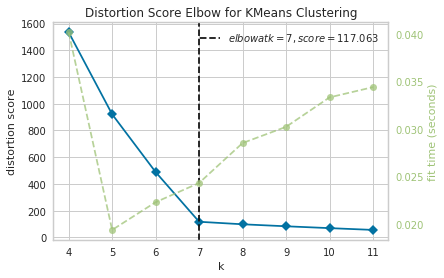

In [24]:
X, y =X, y = make_blobs(n_samples=18, n_features=10, centers=7, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The neighborhoods will be clustered based on their most common venues: 

In [25]:
# set number of clusters
kclusters = 7


BLA_grouped_clustering = BLA_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BLA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 5, 3, 5, 5, 0, 5, 2, 5], dtype=int32)

In [26]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

BLA_merged = BLA.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
BLA_merged = BLA_merged.dropna(subset=['Cluster Labels'])
BLA_merged = BLA_merged.astype({"Cluster Labels": int})

BLA_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Devín,Bratislava Devín,48.174586,16.982610,1,Restaurant,Pizza Place,BBQ Joint,Eastern European Restaurant,Bistro,Gastropub,Food,Donut Shop,Falafel Restaurant,Fast Food Restaurant
1,Devínska Nová Ves,Bratislava Devínska Nová Ves,48.209175,16.973894,1,Pizza Place,Restaurant,New American Restaurant,BBQ Joint,Chinese Restaurant,Soup Place,Fast Food Restaurant,Food,Vietnamese Restaurant,Eastern European Restaurant
2,Dúbravka,Bratislava Dúbravka,48.187089,17.037503,5,Restaurant,Pizza Place,Vietnamese Restaurant,Diner,Eastern European Restaurant,BBQ Joint,Burger Joint,Fast Food Restaurant,Gastropub,Italian Restaurant
3,Jarovce,Bratislava Jarovce,48.065237,17.112942,3,Gastropub,Eastern European Restaurant,Pizza Place,Vietnamese Restaurant,Diner,Hungarian Restaurant,Hot Dog Joint,Greek Restaurant,French Restaurant,Food Truck
4,Karlova Ves,Bratislava Karlova Ves,48.159240,17.052677,5,Restaurant,Pizza Place,Vietnamese Restaurant,Fast Food Restaurant,Gastropub,Snack Place,Burger Joint,Italian Restaurant,Sushi Restaurant,Cafeteria
5,Lamač,Bratislava Lamač,48.191196,17.054279,5,Pizza Place,Restaurant,Snack Place,Asian Restaurant,Diner,Fast Food Restaurant,BBQ Joint,Eastern European Restaurant,Gastropub,Italian Restaurant
6,Nové Mesto,Bratislava Nové Mesto,48.167162,17.138352,0,Italian Restaurant,Vietnamese Restaurant,Restaurant,Bakery,Burger Joint,Salad Place,Turkish Restaurant,Bistro,Eastern European Restaurant,Indian Restaurant
7,Petržalka,Bratislava Petržalka,48.110972,17.111290,5,Pizza Place,Restaurant,Asian Restaurant,Bistro,Eastern European Restaurant,Bakery,Gastropub,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Buffet
8,Podunajské Biskupice,Bratislava Podunajské Biskupice,48.130042,17.207421,2,Pizza Place,Eastern European Restaurant,Restaurant,Slovak Restaurant,Food Court,Diner,Fast Food Restaurant,Vietnamese Restaurant,Bistro,Food Truck
9,Rača,Bratislava Rača,48.211789,17.153433,5,Restaurant,Italian Restaurant,Pizza Place,Diner,Asian Restaurant,Slovak Restaurant,Food Court,Eastern European Restaurant,Bistro,Belgian Restaurant


Here is the visualization of the resulting clusters: 

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BLA_merged['Latitude'], BLA_merged['Longitude'], BLA_merged['Neighborhood'], BLA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.99).add_to(map_clusters)
       
map_clusters

Now let's examine the most interesting/relevant Clusters: 

## 5. Discussion section on observations and recommendations 

### Cluster 0: 

Cluster 0 - This analysis shows that most of restaurants are in the Neighborhoods - Stare Mesto, Nove Mesto, Ruzinov a Vinohrady. The cluster 0 is rather saturated with restaurants and there is a good diversity of all kinds of restaurants. 

Recommendations for this cluster: 
1. Neighborhood Ružinov - open an Italian restaurant
2. Neighborhood Nove Mesto - in Neighborhood Nove Mesto there are 2 districts - Kramare, Koliba which are high-end residential areas but there are no restaurants. One of my recommendation is to start restaurant in that arrea - it can be a luxury Italian or some general restaurant.

In [28]:
BLA_merged.loc[BLA_merged['Cluster Labels'] == 0, BLA_merged.columns[[1] + list(range(5, BLA_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bratislava Nové Mesto,Italian Restaurant,Vietnamese Restaurant,Restaurant,Bakery,Burger Joint,Salad Place,Turkish Restaurant,Bistro,Eastern European Restaurant,Indian Restaurant
11,Bratislava Ružinov,Restaurant,Gastropub,Pizza Place,Vietnamese Restaurant,Bistro,Asian Restaurant,Italian Restaurant,Burger Joint,Turkish Restaurant,Indian Restaurant
12,Bratislava Staré Mesto,Italian Restaurant,Restaurant,Burger Joint,Bistro,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bakery,Thai Restaurant,Pizza Place,Salad Place
14,Bratislava Vinohrady,Restaurant,Italian Restaurant,Pizza Place,Vietnamese Restaurant,Bakery,Bistro,Salad Place,Burger Joint,Chinese Restaurant,Diner


### Cluster 1:

Cluster 1 - The outskirts of Bratislava - small number of restaurants but there are also smaller number of inhabitants. No recommendation for this cluster. 

In [29]:
BLA_merged.loc[BLA_merged['Cluster Labels'] == 1, BLA_merged.columns[[1] + list(range(5, BLA_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bratislava Devín,Restaurant,Pizza Place,BBQ Joint,Eastern European Restaurant,Bistro,Gastropub,Food,Donut Shop,Falafel Restaurant,Fast Food Restaurant
1,Bratislava Devínska Nová Ves,Pizza Place,Restaurant,New American Restaurant,BBQ Joint,Chinese Restaurant,Soup Place,Fast Food Restaurant,Food,Vietnamese Restaurant,Eastern European Restaurant
16,Bratislava Záhorská Bystrica,Restaurant,Pizza Place,Snack Place,BBQ Joint,Tapas Restaurant,Bakery,Gastropub,Food,Eastern European Restaurant,Falafel Restaurant


### Cluster 2:

Cluster 2 - the Bratislava outskirts - small number of restaraunts but both neighborhoods have quite good number inhibitants. 

Recommendations for this cluster: open an Italian restaurant in any of these two neighborhoods.  

In [30]:
BLA_merged.loc[BLA_merged['Cluster Labels'] == 2, BLA_merged.columns[[1] + list(range(5, BLA_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bratislava Podunajské Biskupice,Pizza Place,Eastern European Restaurant,Restaurant,Slovak Restaurant,Food Court,Diner,Fast Food Restaurant,Vietnamese Restaurant,Bistro,Food Truck
15,Bratislava Vrakuňa,Pizza Place,Eastern European Restaurant,Restaurant,Vietnamese Restaurant,Slovak Restaurant,Food Court,Fast Food Restaurant,Diner,Italian Restaurant,Bistro


### Cluster 5:

Cluster 5 - the most of Neighborhoods are in this cluster. General restaurants and Pizza places are most common food venues. These are mostly residential Neighborhood. 

Recommendations for this cluster: open an Italian restaurant in Neighborhood Petržalka. 


In [14]:
BLA_merged.loc[BLA_merged['Cluster Labels'] == 5, BLA_merged.columns[[1] + list(range(5, BLA_merged.shape[1]))]]

NameError: name 'BLA_merged' is not defined

## 6. Conclusions 

Objective of this project was to analyze food venues in Bratislava and come with recommendation for a new restaurant. 

Considering the above data I would recommend the following options: 
         1. Neighborhood Nove Mesto in district Koliba 
         2. Opening Italian restaurant in one Neighborhoods - either in Ruzinov or Petrzalka. 

This analysis used data science techniques. Final decision will require analysis also from financial, environmental, traffic and other perspectives. 
